In [1]:
import numpy as np
import cv2 as cv
import glob

from matplotlib import pyplot as plt

images = glob.glob('./checkerboard_r11_c4/*.jpg')
print(images)

['./checkerboard_r11_c4/PXL_20230717_210646963.jpg', './checkerboard_r11_c4/PXL_20230717_210719461.jpg', './checkerboard_r11_c4/PXL_20230717_210634107.jpg', './checkerboard_r11_c4/PXL_20230717_210618513.jpg', './checkerboard_r11_c4/PXL_20230717_210643308.jpg', './checkerboard_r11_c4/PXL_20230717_210629003.jpg', './checkerboard_r11_c4/PXL_20230717_210705666.jpg', './checkerboard_r11_c4/PXL_20230717_210626148.jpg', './checkerboard_r11_c4/PXL_20230717_210614396.jpg', './checkerboard_r11_c4/PXL_20230717_210639443.jpg', './checkerboard_r11_c4/PXL_20230717_210623369.jpg', './checkerboard_r11_c4/PXL_20230717_210649525.jpg', './checkerboard_r11_c4/PXL_20230717_210610871.jpg', './checkerboard_r11_c4/PXL_20230717_210709804.jpg', './checkerboard_r11_c4/PXL_20230717_210637526.jpg', './checkerboard_r11_c4/PXL_20230717_210716801.jpg', './checkerboard_r11_c4/PXL_20230717_210659716.jpg']


In [2]:
#generate grid Points
objp = []
for x in range(11):
    for y in range(4):
        if x%2 == 0:
            objp.append([x, y, 0])
        else:
            objp.append([x, y+1, 0])
objp = np.array(objp).astype(np.float32)

44
(2160, 3840, 3)


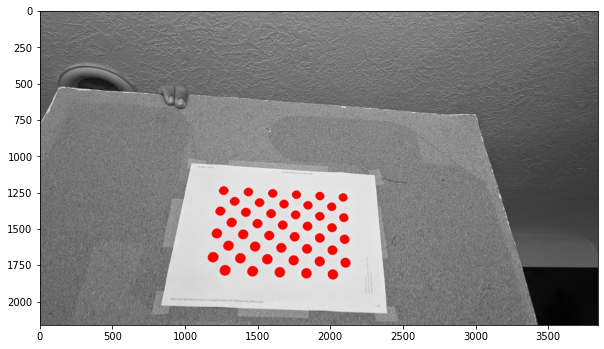

In [3]:
from skimage import draw
def drawKeyPts(im, keyp, color, th):
    draw_shift_bits = 4
    draw_multiplier = 1 << 4
    LINE_AA = 16
    LINE_FILLED = -1
    im = cv.cvtColor(im, cv.COLOR_GRAY2BGR)
    for curKey in keyp:
        center = (int(np.round(curKey.pt[0]*draw_multiplier)), int(np.round(curKey.pt[1]*draw_multiplier)))
        radius = int(np.round(curKey.size/2*draw_multiplier))
        cv.circle(im, center, radius, color, thickness=th, lineType=LINE_FILLED, shift=draw_shift_bits)
        center2 = (int(np.round(curKey.pt[1])), int(np.round(curKey.pt[0])))
        radius2 = int(np.round(curKey.size/2))
        rr, cc = draw.disk(center2, radius2, shape=im.shape)
        im[rr, cc,:] = np.array(color)
    return im


# Setup SimpleBlobDetector parameters.
blobParams = cv.SimpleBlobDetector_Params()

# Change thresholds
blobParams.minThreshold = 8
blobParams.maxThreshold = 200

# Filter by Area.
blobParams.filterByArea = True
blobParams.minArea = 1000     # minArea may be adjusted to suit for your experiment
blobParams.maxArea = 8500   # maxArea may be adjusted to suit for your experiment

# Filter by Circularity
blobParams.filterByCircularity = True
blobParams.minCircularity = 0.2

# Filter by Convexity
blobParams.filterByConvexity = True
blobParams.minConvexity = 0.87


# Create a detector with the parameters
blobDetector = cv.SimpleBlobDetector_create(blobParams)

image = cv.imread(images[4])
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

keypoints = blobDetector.detect(gray) # Detect blobs.
print(len(keypoints))
print(image.shape)
img_with_keypoints = drawKeyPts(gray, keypoints, (255,0,0), 1)


fig = plt.figure(figsize=(10, 10))
plt.imshow(img_with_keypoints)

In [4]:
cornerResultList = []
realWorldCornersPoints = []
imageCornerPoints = []

for path in images:
    img = cv.imread(path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blurred = cv.medianBlur(gray, 7)
    ret, corners = cv.findCirclesGrid(blurred, (4, 11), None, flags = cv.CALIB_CB_ASYMMETRIC_GRID + cv.CALIB_CB_CLUSTERING, blobDetector = blobDetector)
    if ret == True:
        #  cornerSubPix does not work on the circle grid at all. Also, it mutates the original point list :(
        cornerResultList.append({"corners":corners,"img":img, "blurred":blurred})
        realWorldCornersPoints.append(objp)
        imageCornerPoints.append(corners[:,0,:])
print('found', len(cornerResultList), '/', len(images), 'viable images')




found 11 / 17 viable images


(2160, 3840, 3) (2160, 3840)


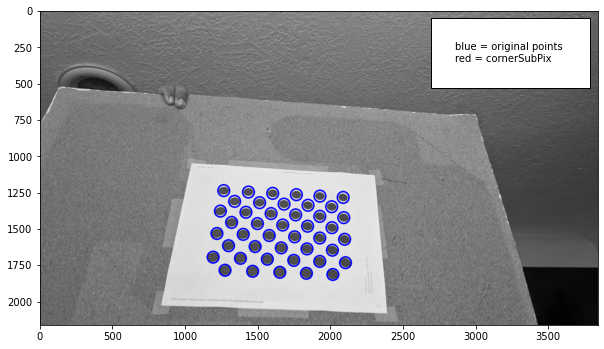

In [6]:
from skimage import draw
from skimage import morphology
import math
def drawCircleGrid(img, keyp, color, thickness = 3):
    im = None
    if len(img.shape) > 2:
        im = img.copy()
    else :
        im = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    mask = np.zeros((im.shape[0], im.shape[1]))
    print(im.shape,mask.shape)
    for pt in keyp:
        # print(pt[0][0], pt[0][1])
        x = int(round(pt[0][0]))
        y = int(round(pt[0][1]))
        rr, cc = draw.circle_perimeter(y,x, radius=40, shape=im.shape)
        mask[rr,cc] = 1
    dilated = morphology.dilation(mask, morphology.disk(radius=thickness))
        # print(rr)
    im[dilated == 1] = np.array(color)
    return im

test = cornerResultList[4]
blurred = test['blurred']
corners = test['corners']

# print(test)
img2 = drawCircleGrid(blurred, corners,(0,0,255),5)

fig = plt.figure(figsize=(10, 10))
fig.text(0.702, 0.65, 'blue = original points \nred = cornerSubPix', bbox={'facecolor': 'white', 'pad': 24})
plt.imshow(img2)

In [ ]:

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(realWorldCornersPoints,imageCornerPoints,  gray.shape[::-1], None, None)
# print(ret, mtx, dist, rvecs, tvecs)


43.03711413945319 [[2.97390168e+04 0.00000000e+00 1.89309054e+03]
 [0.00000000e+00 1.81710546e+04 1.04116530e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[ 1.20076943e+01 -1.44528740e+03  8.17717781e-02  1.29637007e-01
  -1.49479233e+01]] [array([[0.02980658],
       [1.93146461],
       [0.02065356]]), array([[ 6.08378031e-02],
       [ 1.96016012e+00],
       [-1.25520564e-04]]), array([[-0.07883353],
       [-4.3633654 ],
       [-0.01600865]]), array([[ 0.74229442],
       [-1.88400981],
       [ 0.02865683]]), array([[-0.06669521],
       [ 1.96016141],
       [-0.0119111 ]]), array([[-0.02796993],
       [-1.87068288],
       [ 0.06190408]]), array([[0.49779183],
       [1.88740786],
       [0.07831022]]), array([[ 0.00511887],
       [-1.89545846],
       [ 0.01673906]]), array([[-0.06479825],
       [ 1.90949148],
       [ 0.03755782]]), array([[ 0.06497894],
       [ 1.81188317],
       [-0.04320751]]), array([[ 0.01968559],
       [-1.90204668],
       [ 0.06372946]

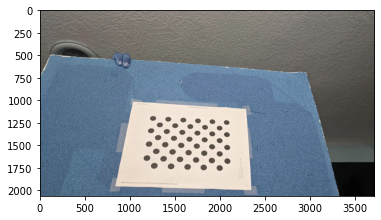

In [ ]:
img = cornerResultList[4]['img']
h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

plt.imshow(dst)

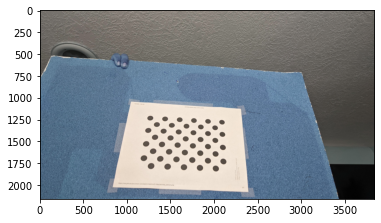

In [ ]:
plt.imshow(img)